# TP 2 : Computer Vision

## Part 1 : segmentation

In this part of the TP, we are going to implement two approaches to image segmentation :

- algorithm of Otsu (histogram-based segmentation)
- a simple region-growing based algorithm

First, let us load some packages and define some helper functions (as in the previous TP)

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'crossing'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

(800, 586)

## Otsu's algorithm

Otsu's method is based on finding a threshold to split the image into two separate segments, based simply on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the following criterion :

$argmin_{\tau} \omega_0(\tau)\sigma_0(\tau) + \omega_1(\tau)\sigma_1(t)$

where

- $\sigma_0(\tau)$ and $\sigma_1(\tau)$ are the variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are weights of the first and second regions

and 

- $\omega_0(\tau) = \sum_{p \in \Omega} \mathbb{1}_{\tau}(I(p)), \qquad$
- $\omega_1(\tau) = \sum_{p \in \Omega} 1-\mathbb{1}_{\tau}(I(p))$

and 

$\mathbb{1}_{\tau}(I(p)) =\begin{cases}
        1 \; \text{if} \: I(p)<=\tau\\
        0 \; \text{otherwise}
\end{cases}$

Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions : you cannot have a region with no pixels. Furthemore, remember that the image is normalised between 0 and 1, with 256 discrete values. Choose the threshold values accordingly.

In [2]:
# This function returns the segmentation of the algorithm of otsu, as well as the threshold found
def segmentation_otsu(img):

    # FILL IN CODE HERE
#     img = img * 255
    img_flat = np.reshape(img, img.size)

    [hist, _] = np.histogram(img, bins = 256)

    tau_out = -1.
    arg_min = np.infty
    
    
    for t in range(256):
        
        w0 = np.sum(hist[:t])
        w1 = np.sum(hist[t:])
        
        s0 = np.std(img_flat[img_flat<=t/256.]) ** 2
        s1 = np.std(img_flat[img_flat>t/256.]) ** 2

        arg = w0*s0 + w1*s1
        

        if arg < arg_min:
            arg_min = arg
            tau_out = float(t)/256.

    seg_otstu_out = img.copy()
    seg_otstu_out[seg_otstu_out<=tau_out] = 0
    seg_otstu_out[seg_otstu_out>tau_out] = 1
    
    return seg_otstu_out,tau_out

Carry out the segmentation on the input image and display the result

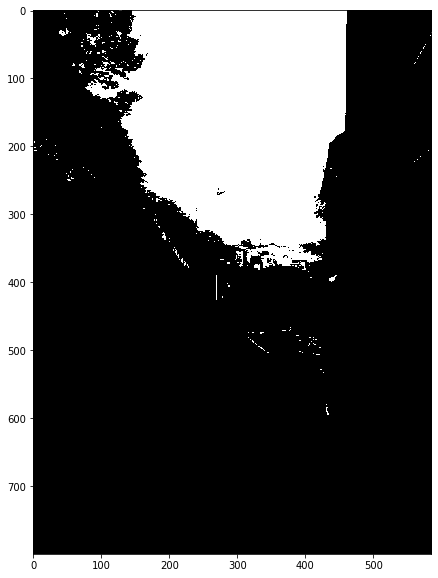

In [3]:
img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

__Question__ What problem can you see with the segmentation result ? What morphological technique(s) (seen in the lesson) could you use to clean the result up ? 

__Answer__ The resulting image of the segmentation is noisy, contains a lot of small bright pixel clusters  in the foreground as well as small dark objects in the background.

We can use a succession of erosion and dilation operators, more specifically closing and opening morphological operations to remove the noise.

Carry out this technique to clean up the output image, and imwrite the result. You can find the necessary function(s) in the following package :

skimage.morphology

Choose the neighbourhood parameter of the functions to obtain the best results.

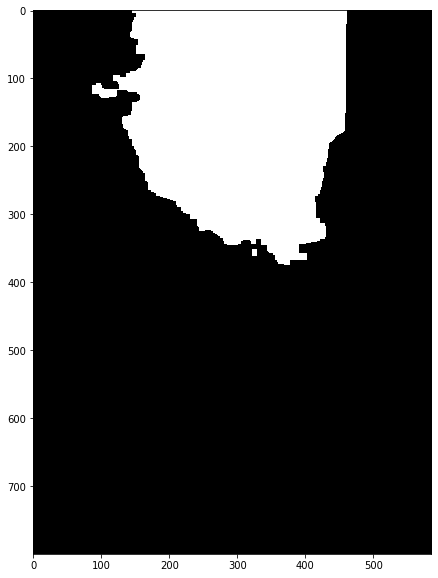

In [4]:
from skimage.morphology import opening, closing

structure = np.ones((7,7))
img_out_otsu_cleaned = closing(opening(img_out_otsu, structure), structure)

display_image(img_out_otsu_cleaned)
write_image(img_out_otsu_cleaned,file_name+'_segmentation_otsu_cleaned_1.png')

__Question__ In which order did you propose to carry out the morphological operations ? Why ?

__Answer__ We carry out a morphological opening then a morphological closing. The former aids in removing small bright spots and connect small dark cracks, while the latter does the opposite. Opening removes small objects from the foreground (usually taken as the bright pixels) of an image, placing them in the background, while closing removes small holes in the foreground, changing small islands of background into foreground. We apply it in this order because there are more noisy white points than the reverse. We should use an opening first to we able to counter the "salt" dots and then use a closing to "smooth" the image clean.

Let's change the image, and carry out the segmentation again.

/Users/amineabboudi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/amineabboudi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/amineabboudi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


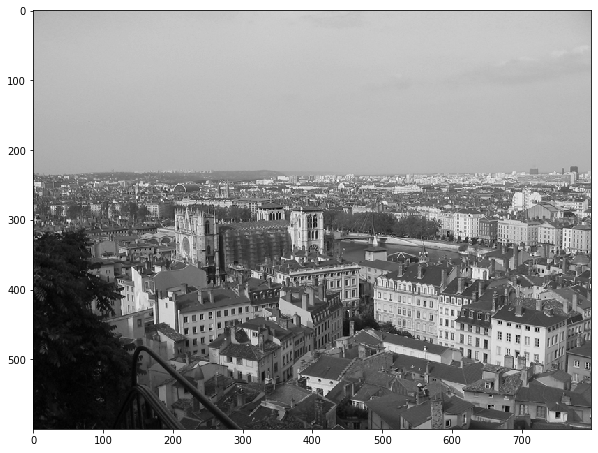

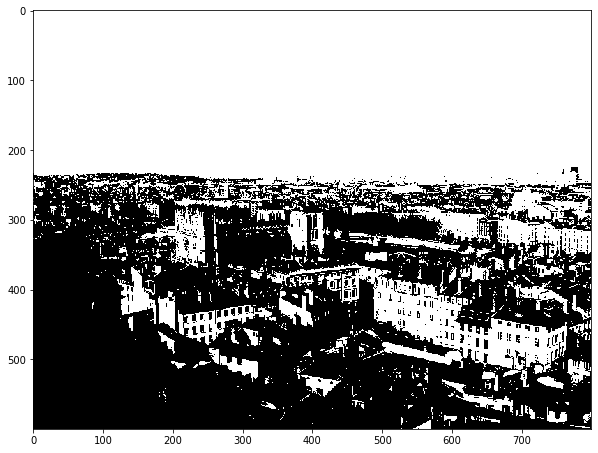

In [5]:
file_name = 'town'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

img_out_otsu,tau = segmentation_otsu(img_gray)
display_image(img_out_otsu)
write_image(img_out_otsu,file_name+'_segmentation_otsu.png')

As we can see, there is no notion of connectivity in the algorithm of Otsu (two regions far away can be in the same segment). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add new pixels progressively to the region. More precisely, at each iteration of the algorithm, we attempt to add the neighbours of the pixels in the current segmentation. We add new pixels according to the criterion :

- $I(p)$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

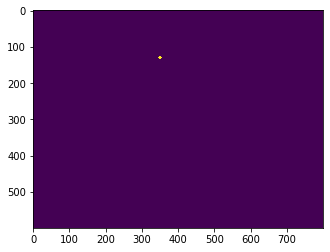

In [6]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt, img_shape, r0 = 5):
    # FILL IN CODE HERE 
    
    x0, y0 = seed_pt[1], seed_pt[0]
    seg_init = np.zeros(img_shape)

    A, B = np.meshgrid(np.arange(img_shape[0]),np.arange(img_shape[1]))
    
    max_dist = np.sqrt((A-x0)**2 + (B-y0)**2)
    
    seg_init[np.where(max_dist<r0)] = 1
    
    return seg_init

plt.imshow(initialize_segmentation(seed_pt = np.asarray([130,350]), img_shape = img_gray.shape))

Now, create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

__IMPORTANT NOTE__ Once a pixel has been added to the region, it is in the region permanently : it is not checked again in further iterations (otherwise we could remove pixels which were added).

In [7]:
from scipy.ndimage import binary_dilation

# This function returns both the final segmentation and the initialisation
def segmentation_region_growing(img,seed_pt,tau):
    # FILL IN CODE HERE
    growing = True
    seg_init = initialize_segmentation(seed_pt=seed_pt, img_shape=img.shape)
    seg_mid = seg_init.copy()

    while growing:
        mu = img[seg_mid==1].mean()
        add_pixels = binary_dilation(seg_mid) - seg_mid
        cond = (add_pixels==1) & (abs(img-mu) < tau)
        seg_mid[cond] = 1
        growing = np.any(cond)
        
    seg = seg_mid * img.copy()
    return seg, seg_init

Carry out the segmentation on the input image with the seed point and threshold specified in the following code :

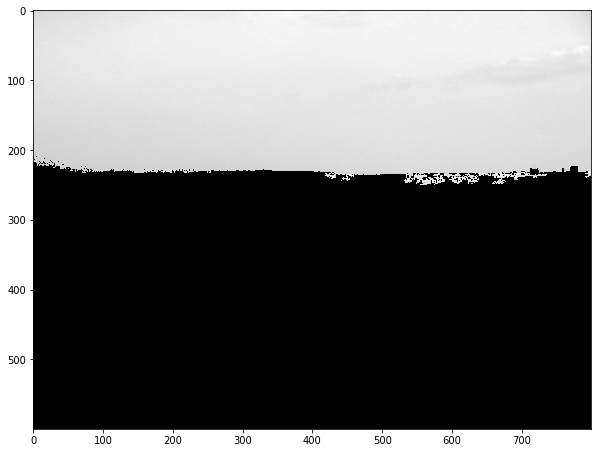

In [8]:
seed_pt = np.asarray([130,350])
tau = 20.0 * (1.0/256.0)
img_out_region_growing,seg_init = segmentation_region_growing(img_gray,seed_pt,tau)
display_image(img_out_region_growing)
write_image(seg_init,file_name+'_segmentation_region_growing_init.png')
write_image(img_out_region_growing,file_name+'_segmentation_region_growing.png')